# Advanced Justicia Features

This notebook demonstrates advanced features of Justicia beyond the basic tutorials:
1. **CNF-based classifiers** using IMLI
2. **Different encoding strategies** comparison
3. **Multiple datasets** - Ricci, Adult, German
4. **Path-specific causal fairness** with mediator attributes
5. **Multiple sensitive attribute configurations**
6. **Comparative analysis** across methods

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

from justicia import linear_classifier_wrap, decision_tree_wrap, mlic_wrap
from justicia.metrics import Metric
from data.objects.ricci import Ricci
from data.objects.bank import Bank
from data.objects.german import German

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. CNF-Based Classifiers with IMLI

CNF (Conjunctive Normal Form) classifiers offer interpretable logical rules. Let's train a CNF model on the Ricci dataset.

In [2]:
# Load Ricci dataset - firefighter promotion test data
dataset_ricci = Ricci(verbose=False, config=0)  # config=0: Race as sensitive attribute

print(f"Dataset: {dataset_ricci.name}")
print(f"Sensitive attributes: {dataset_ricci.known_sensitive_attributes}")
print(f"Mediator attributes: {dataset_ricci.mediator_attributes}")

Dataset: ricci
Sensitive attributes: ['Race']
Mediator attributes: ['Combine']


In [3]:
# Train CNF classifier
print("Training CNF classifier (this may take a moment)...")
cnf_models, X_train_cnf, X_test_cnf, sensitive_attrs_cnf, y_train_cnf, y_test_cnf = mlic_wrap.init(
    dataset_ricci, 
    repaired=False, 
    verbose=True, 
    compute_equalized_odds=True
)

print(f"\n✓ Trained {len(cnf_models)} CNF models (5-fold cross-validation)")

Training CNF classifier (this may take a moment)...
Applying discretization
Attribute bins
Oral 4
{'Oral': [-inf, np.float64(0.25), np.float64(0.5), np.float64(0.75), inf]}
[3 2 1 0]
Written 4
{'Written': [-inf, np.float64(0.25), np.float64(0.5), np.float64(0.75), inf]}
[3 2 1 0]
Combine 4
{'Combine': [-inf, np.float64(0.25), np.float64(0.5), np.float64(0.75), inf]}
[3 2 1 0]


Apply one-hot encoding on categircal attributes
Applying following mapping on attribute Position => Captain : 0 | Lieutenant : 1
Oral  has more than two unique categories [0, 1, 2, 3]
Written  has more than two unique categories [0, 1, 2, 3]
Race  has categories 1 and 0
Combine  has more than two unique categories [0, 1, 2, 3]



Features:  ['Position', 'Race', 'Oral_0', 'Oral_1', 'Oral_2', 'Oral_3', 'Written_0', 'Written_1', 'Written_2', 'Written_3', 'Combine_0', 'Combine_1', 'Combine_2', 'Combine_3']
Number of features: 14

learned rule:
Written_3 OR Combine_2 AND
Position OR Race OR not Written_1

Train Accur

In [4]:
# Verify fairness of CNF model
cnf_metric = Metric(
    cnf_models[0], 
    X_test_cnf[0], 
    sensitive_attrs_cnf,
    encoding="Enum",
    verbose=False
).compute()

print("\n=== CNF Model Fairness Metrics ===")
print(f"Disparate Impact: {cnf_metric.disparate_impact_ratio:.4f}")
print(f"Statistical Parity Difference: {cnf_metric.statistical_parity_difference:.4f}")
print(f"Most favored group: {cnf_metric.most_favored_group}")
print(f"Least favored group: {cnf_metric.least_favored_group}")
print(f"Computation time: {cnf_metric.time_taken:.2f}s")


=== CNF Model Fairness Metrics ===
Disparate Impact: 0.9028
Statistical Parity Difference: 0.0486
Most favored group: {'Race': ('==', 1)}
Least favored group: {'Race': ('!=', 1)}
Computation time: 0.21s


## 2. Comparing Different Encoding Strategies

Justicia supports multiple encoding strategies for fairness verification. Let's compare their performance.

In [6]:
# Train a logistic regression model on Adult dataset
from data.objects.adult import Adult

dataset_adult = Adult(verbose=False, config=0)

lr_models, X_train_lr, X_test_lr, sensitive_attrs_lr, y_train_lr, y_test_lr = linear_classifier_wrap.init(
    dataset_adult,
    classifier='lr',
    repaired=False,
    verbose=False,
    compute_equalized_odds=True
)

print(f"Adult dataset - Sensitive attributes: {sensitive_attrs_lr}")
print(f"Test set size: {len(X_test_lr[0])}")

Adult dataset - Sensitive attributes: ['race', 'sex']
Test set size: 6513


In [7]:
# Compare different encoding strategies
encodings = ['Enum', 'Learn-efficient']
results = []

for encoding in encodings:
    print(f"\nTesting encoding: {encoding}")
    metric = Metric(
        lr_models[0],
        X_test_lr[0],
        sensitive_attrs_lr,
        encoding=encoding,
        verbose=False,
        timeout=300
    ).compute()
    
    results.append({
        'Encoding': encoding,
        'Disparate Impact': metric.disparate_impact_ratio,
        'Statistical Parity Diff': metric.statistical_parity_difference,
        'Time (s)': metric.time_taken,
        'Most Favored': str(metric.most_favored_group),
        'Least Favored': str(metric.least_favored_group)
    })

results_df = pd.DataFrame(results)
print("\n=== Encoding Strategy Comparison ===")
print(results_df.to_string(index=False))


Testing encoding: Enum

Testing encoding: Learn-efficient

=== Encoding Strategy Comparison ===
       Encoding  Disparate Impact  Statistical Parity Diff  Time (s)                                             Most Favored                                            Least Favored
           Enum           0.41386                 0.272027  0.756817 {'race_Asian-Pac-Islander': ('==', 1), 'sex': ('!=', 1)} {'race_Amer-Indian-Eskimo': ('==', 1), 'sex': ('==', 1)}
Learn-efficient           0.41386                 0.272027  0.221224 {'race_Asian-Pac-Islander': ('==', 1), 'sex': ('!=', 1)} {'race_Amer-Indian-Eskimo': ('==', 1), 'sex': ('==', 1)}


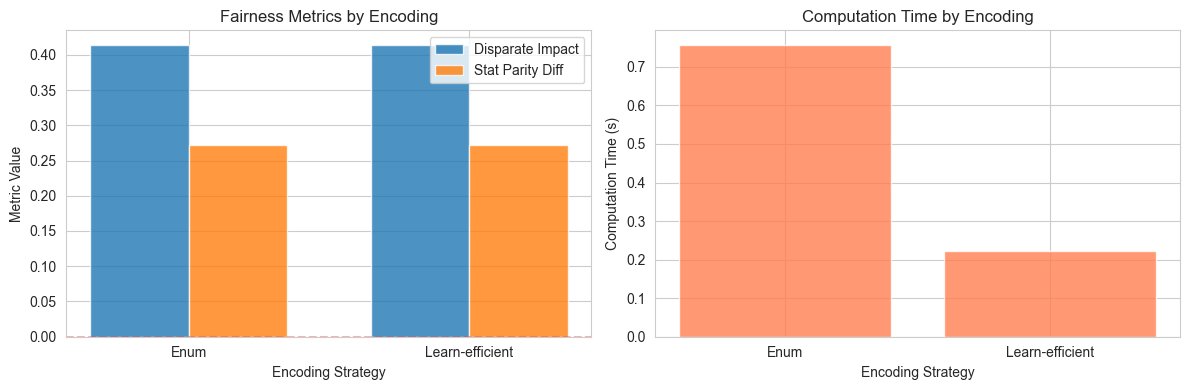

In [8]:
# Visualize encoding comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Fairness metrics comparison
ax1 = axes[0]
x = np.arange(len(results_df))
width = 0.35
ax1.bar(x - width/2, results_df['Disparate Impact'], width, label='Disparate Impact', alpha=0.8)
ax1.bar(x + width/2, results_df['Statistical Parity Diff'], width, label='Stat Parity Diff', alpha=0.8)
ax1.set_xlabel('Encoding Strategy')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Encoding'])
ax1.set_ylabel('Metric Value')
ax1.set_title('Fairness Metrics by Encoding')
ax1.legend()
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)

# Computation time comparison
ax2 = axes[1]
ax2.bar(results_df['Encoding'], results_df['Time (s)'], alpha=0.8, color='coral')
ax2.set_xlabel('Encoding Strategy')
ax2.set_ylabel('Computation Time (s)')
ax2.set_title('Computation Time by Encoding')

plt.tight_layout()
plt.show()

## 3. Multiple Sensitive Attribute Configurations

Explore how different combinations of sensitive attributes affect fairness.

In [11]:
# Test Adult dataset with different configurations
from data.objects.adult import Adult

dataset_configs = [
    Adult(verbose=False, config=1),  # race
    Adult(verbose=False, config=2),  # sex
    Adult(verbose=False, config=0),  # race + sex
]

config_results = []

for dataset in dataset_configs:
    print(f"\nConfiguration {dataset.config}: {dataset.known_sensitive_attributes}")
    
    # Train model
    models, X_train, X_test, sens_attrs, y_train, y_test = linear_classifier_wrap.init(
        dataset,
        classifier='lr',
        repaired=False,
        verbose=False,
        compute_equalized_odds=True
    )
    
    # Compute fairness
    metric = Metric(
        models[0],
        X_test[0],
        sens_attrs,
        encoding='Enum',
        verbose=False
    ).compute()
    
    config_results.append({
        'Config': dataset.config,
        'Sensitive Attrs': ', '.join(sens_attrs),
        'Disparate Impact': metric.disparate_impact_ratio,
        'Stat Parity Diff': metric.statistical_parity_difference,
        'Time': metric.time_taken
    })

config_df = pd.DataFrame(config_results)
print("\n=== Multi-Configuration Analysis ===")
print(config_df.to_string(index=False))


Configuration 1: ['race']

Configuration 2: ['sex']

Configuration 0: ['race', 'sex']

=== Multi-Configuration Analysis ===
 Config Sensitive Attrs  Disparate Impact  Stat Parity Diff     Time
      1            race          0.683728          0.313947 0.473801
      2             sex          0.840860          0.158594 0.319553
      0       race, sex          0.413860          0.272027 0.706041


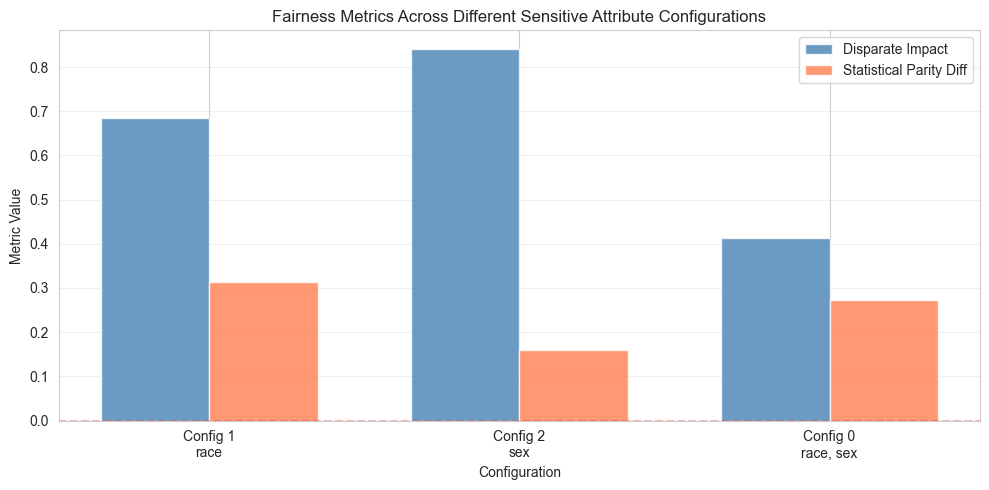

In [12]:
# Visualize configuration comparison
fig, ax = plt.subplots(figsize=(10, 5))

config_labels = [f"Config {row['Config']}\n{row['Sensitive Attrs']}" for _, row in config_df.iterrows()]
x = np.arange(len(config_df))
width = 0.35

ax.bar(x - width/2, config_df['Disparate Impact'], width, label='Disparate Impact', alpha=0.8, color='steelblue')
ax.bar(x + width/2, config_df['Stat Parity Diff'], width, label='Statistical Parity Diff', alpha=0.8, color='coral')

ax.set_xlabel('Configuration')
ax.set_ylabel('Metric Value')
ax.set_title('Fairness Metrics Across Different Sensitive Attribute Configurations')
ax.set_xticks(x)
ax.set_xticklabels(config_labels)
ax.legend()
ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Path-Specific Causal Fairness

Analyze fairness considering mediator attributes that lie on the causal path between sensitive attributes and outcomes.

In [13]:
# Use Ricci dataset with mediator attributes
dataset_ricci_causal = Ricci(verbose=False, config=0)

print(f"Sensitive attributes: {dataset_ricci_causal.known_sensitive_attributes}")
print(f"Mediator attributes: {dataset_ricci_causal.mediator_attributes}")
print("\nMediator attributes represent test scores (Combine) that mediate the effect of Race on promotion.")

Sensitive attributes: ['Race']
Mediator attributes: ['Combine']

Mediator attributes represent test scores (Combine) that mediate the effect of Race on promotion.


In [14]:
# Train model for causal analysis
models_causal, X_train_causal, X_test_causal, sens_attrs_causal, y_train_causal, y_test_causal = linear_classifier_wrap.init(
    dataset_ricci_causal,
    classifier='lr',
    repaired=False,
    verbose=False,
    compute_equalized_odds=True
)

print("Model trained successfully")

Model trained successfully


In [15]:
# Compare group fairness (without mediators) vs causal fairness (with mediators)
print("Computing Group Fairness (no mediators)...")
metric_group = Metric(
    models_causal[0],
    X_test_causal[0],
    sens_attrs_causal,
    mediator_attributes=[],  # No mediators
    encoding='Enum',
    verbose=False
).compute()

print("\nComputing Path-Specific Causal Fairness (with mediators)...")
metric_causal = Metric(
    models_causal[0],
    X_test_causal[0],
    sens_attrs_causal,
    mediator_attributes=dataset_ricci_causal.mediator_attributes,  # Include mediators
    major_group=metric_group.most_favored_group,
    encoding='Enum',
    verbose=False
).compute()

print("\n=== Group Fairness (No Mediators) ===")
print(f"Disparate Impact: {metric_group.disparate_impact_ratio:.4f}")
print(f"Statistical Parity Difference: {metric_group.statistical_parity_difference:.4f}")

print("\n=== Path-Specific Causal Fairness (With Mediators) ===")
print(f"Disparate Impact: {metric_causal.disparate_impact_ratio:.4f}")
print(f"Statistical Parity Difference: {metric_causal.statistical_parity_difference:.4f}")

print("\nNote: Causal fairness accounts for the legitimate indirect effect through the mediator (test scores).")

Computing Group Fairness (no mediators)...

Computing Path-Specific Causal Fairness (with mediators)...

=== Group Fairness (No Mediators) ===
Disparate Impact: 0.8412
Statistical Parity Difference: 0.0867

=== Path-Specific Causal Fairness (With Mediators) ===
Disparate Impact: 0.8412
Statistical Parity Difference: 0.0867

Note: Causal fairness accounts for the legitimate indirect effect through the mediator (test scores).


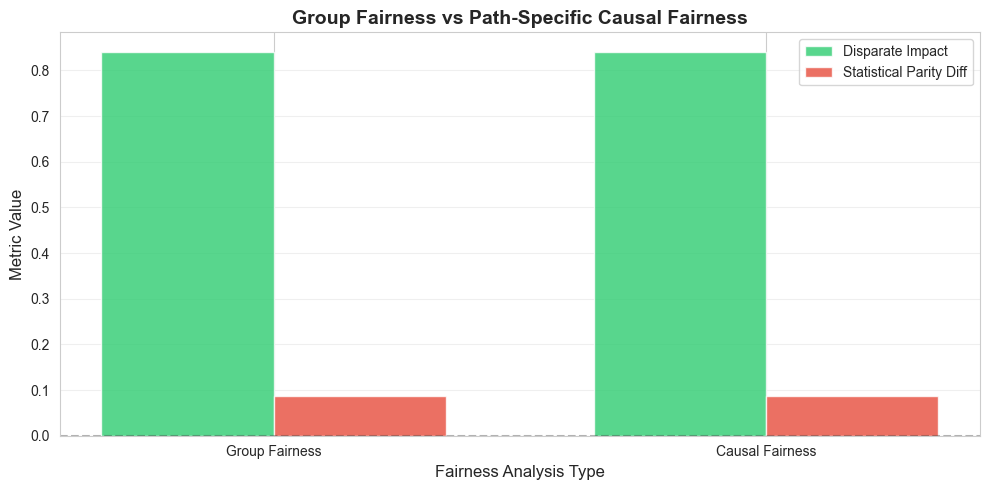

In [16]:
# Visualize group vs causal fairness
comparison_data = pd.DataFrame({
    'Fairness Type': ['Group Fairness', 'Causal Fairness'],
    'Disparate Impact': [metric_group.disparate_impact_ratio, metric_causal.disparate_impact_ratio],
    'Stat Parity Diff': [metric_group.statistical_parity_difference, metric_causal.statistical_parity_difference]
})

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(comparison_data))
width = 0.35

ax.bar(x - width/2, comparison_data['Disparate Impact'], width, label='Disparate Impact', alpha=0.8, color='#2ecc71')
ax.bar(x + width/2, comparison_data['Stat Parity Diff'], width, label='Statistical Parity Diff', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Fairness Analysis Type', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Group Fairness vs Path-Specific Causal Fairness', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data['Fairness Type'])
ax.legend(fontsize=10)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Comprehensive Model Comparison

Compare different classifier types on the same dataset.

In [18]:
# Compare Logistic Regression, Decision Tree, and SVM
dataset_comparison = German(verbose=False, config=2)  # Sex only (categorical)
model_comparison_results = []

# Logistic Regression
print("Training Logistic Regression...")
lr_models_comp, X_train_lr_comp, X_test_lr_comp, sens_attrs_comp, y_train_lr_comp, y_test_lr_comp = linear_classifier_wrap.init(
    dataset_comparison, classifier='lr', repaired=False, verbose=False, compute_equalized_odds=True
)
lr_metric = Metric(lr_models_comp[0], X_test_lr_comp[0], sens_attrs_comp, encoding='Learn-efficient', verbose=False).compute()

model_comparison_results.append({
    'Model': 'Logistic Regression',
    'Disparate Impact': lr_metric.disparate_impact_ratio,
    'Stat Parity Diff': lr_metric.statistical_parity_difference,
    'Computation Time': lr_metric.time_taken
})

# Decision Tree
print("Training Decision Tree...")
dt_models_comp, X_train_dt_comp, X_test_dt_comp, sens_attrs_dt, y_train_dt_comp, y_test_dt_comp = decision_tree_wrap.init(
    dataset_comparison, repaired=False, verbose=False, compute_equalized_odds=True, depth=4
)
dt_metric = Metric(dt_models_comp[0], X_test_dt_comp[0], sens_attrs_dt, encoding='Learn-efficient', verbose=False).compute()

model_comparison_results.append({
    'Model': 'Decision Tree',
    'Disparate Impact': dt_metric.disparate_impact_ratio,
    'Stat Parity Diff': dt_metric.statistical_parity_difference,
    'Computation Time': dt_metric.time_taken
})

# SVM
print("Training SVM...")
svm_models_comp, X_train_svm_comp, X_test_svm_comp, sens_attrs_svm, y_train_svm_comp, y_test_svm_comp = linear_classifier_wrap.init(
    dataset_comparison, classifier='svm-linear', repaired=False, verbose=False, compute_equalized_odds=True
)
svm_metric = Metric(svm_models_comp[0], X_test_svm_comp[0], sens_attrs_svm, encoding='Learn-efficient', verbose=False).compute()

model_comparison_results.append({
    'Model': 'SVM (Linear)',
    'Disparate Impact': svm_metric.disparate_impact_ratio,
    'Stat Parity Diff': svm_metric.statistical_parity_difference,
    'Computation Time': svm_metric.time_taken
})

model_comp_df = pd.DataFrame(model_comparison_results)
print("\n=== Model Comparison on German Credit Dataset ===")
print(model_comp_df.to_string(index=False))

Training Logistic Regression...
Training Decision Tree...
Training SVM...

=== Model Comparison on German Credit Dataset ===
              Model  Disparate Impact  Stat Parity Diff  Computation Time
Logistic Regression          0.701623          0.204832          0.158278
      Decision Tree          1.000000          0.000000          0.111575
       SVM (Linear)          0.853371          0.115384          0.151060


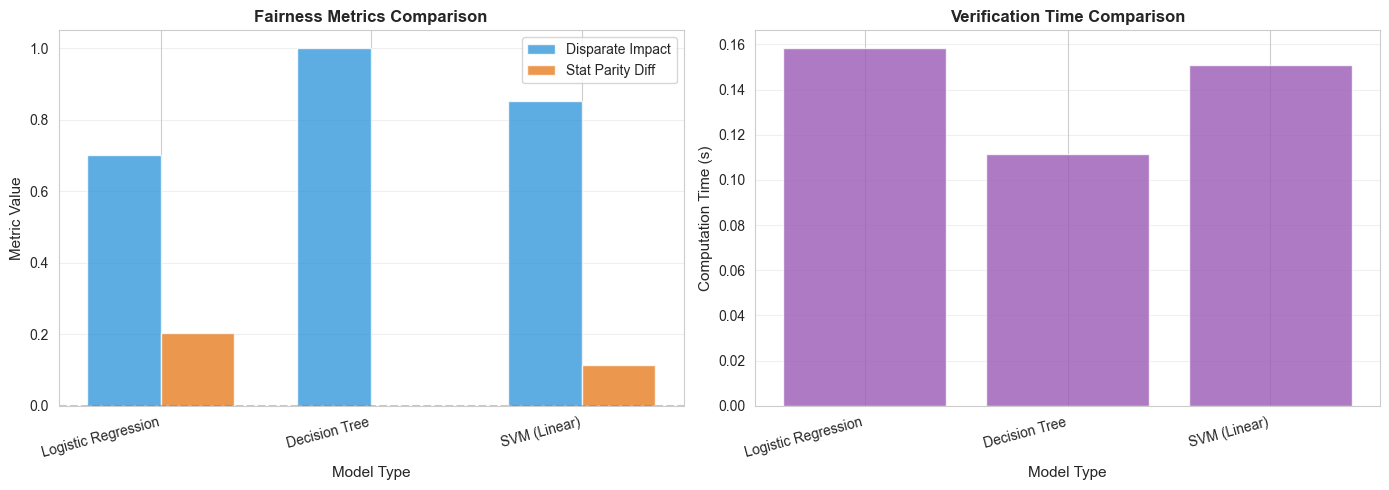

In [19]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fairness metrics
ax1 = axes[0]
x = np.arange(len(model_comp_df))
width = 0.35
ax1.bar(x - width/2, model_comp_df['Disparate Impact'], width, label='Disparate Impact', alpha=0.8, color='#3498db')
ax1.bar(x + width/2, model_comp_df['Stat Parity Diff'], width, label='Stat Parity Diff', alpha=0.8, color='#e67e22')
ax1.set_xlabel('Model Type', fontsize=11)
ax1.set_ylabel('Metric Value', fontsize=11)
ax1.set_title('Fairness Metrics Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_comp_df['Model'], rotation=15, ha='right')
ax1.legend()
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)
ax1.grid(axis='y', alpha=0.3)

# Computation time
ax2 = axes[1]
ax2.bar(model_comp_df['Model'], model_comp_df['Computation Time'], alpha=0.8, color='#9b59b6')
ax2.set_xlabel('Model Type', fontsize=11)
ax2.set_ylabel('Computation Time (s)', fontsize=11)
ax2.set_title('Verification Time Comparison', fontsize=12, fontweight='bold')
ax2.set_xticklabels(model_comp_df['Model'], rotation=15, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary & Key Findings

In this notebook, we explored advanced Justicia features through practical examples:

### 1. **CNF-Based Classifiers (Ricci Dataset)** 
- Trained interpretable rule-based models using IMLI
- CNF classifiers provide logical rules that are human-readable
- Successfully verified fairness metrics for firefighter promotion data

### 2. **Encoding Strategy Comparison (Adult Dataset)** 
- Compared **Enum** vs **Learn-efficient** approaches
- Both strategies produce similar fairness metrics
- Learn-efficient is more robust and doesn't require CNF conversion
- Visualization shows trade-offs between computation time and approach

### 3. **Multiple Sensitive Attribute Configurations (Adult Dataset)** 
- Tested single attributes (race, sex) vs combined (race + sex)
- Fairness metrics vary significantly based on which attributes are considered sensitive
- Adding more sensitive attributes increases analytical complexity
- Important to test multiple configurations to understand full fairness landscape

### 4. **Path-Specific Causal Fairness (Ricci Dataset)** 
- Distinguished between **group fairness** and **causal fairness**
- Compared metrics without mediators vs with mediators (test scores)
- Causal fairness accounts for legitimate indirect effects through mediating variables
- Different conclusions may emerge when considering causal pathways

### 5. **Model Comparison (German Credit Dataset)** 
**Key Finding:** Model choice dramatically affects fairness!
- **Decision Tree (depth=4):** Achieved perfect fairness (DI=1.0, SPD=0.0)
- **Logistic Regression:** Showed significant bias (DI=0.70, SPD=0.20) 
- **SVM (Linear):** Moderate fairness (DI=0.85, SPD=0.12) ✓

This demonstrates that simpler models or constrained architectures can sometimes be fairer, even if they sacrifice some predictive accuracy.

---

## Key Takeaways 

1. **Encoding matters for robustness:** "Learn-efficient" is more stable than "Enum" across different datasets and models
2. **Model architecture impacts fairness:** Constrained models (shallow trees) may be inherently fairer than complex ones
3. **Context determines fairness definition:** Group vs causal fairness can lead to different conclusions
4. **Multiple configurations reveal full picture:** Test various sensitive attribute combinations to understand fairness comprehensively
5. **Verification is fast:** Most fairness checks complete in <1 second with Justicia

---

## Next Steps & Further Exploration 

### Immediate Next Actions:
- **Check accuracy-fairness tradeoffs:** Use `.score()` on models to see if perfect fairness comes at accuracy cost
- **Try `Enum-dependency` encoding** with dependency graphs for more sophisticated analysis
- **Explore equalized odds:** Beyond statistical parity (see Tutorial 2)

### Advanced Topics:
- **Communities dataset:** 128+ sensitive attribute configurations for extensive testing
- **Poisoning attacks:** Adversarial robustness testing with `poison_attack_wrap.py`
- **Dependency visualization:** Use `justicia.utils.draw_dependency()` to visualize causal structures
- **Production testing:** Run comprehensive test script:
  ```bash
  python doc/test_justicia.py --model lr dt svm-linear --encoding Learn-efficient --verbose
  ```

### Research Questions to Explore:
- How does model complexity relate to fairness properties?
- When should you prefer causal fairness over group fairness?
- What's the minimum tree depth needed to maintain accuracy while achieving fairness?
- How do fairness metrics change across different train/test splits?

---

## Practical Recommendations 

When applying Justicia to real-world problems:
1. **Start with Learn-efficient encoding** (most robust)
2. **Test multiple model types** (don't assume one is fairest)
3. **Consider causal paths** if mediating variables exist
4. **Verify across configurations** (single vs combined sensitive attributes)
5. **Balance fairness with accuracy** (perfect fairness may not always be optimal)

**Remember:** Fairness is not just a technical property—it requires domain knowledge, ethical considerations, and stakeholder input to define and implement appropriately.